# Imports

Most of functionality is hidden in the relevant modules, imported below.

In [1]:
import numpy as np
import faiss
import time
import pandas as pd
from tqdm import tqdm
import joblib
import os

# Custom modules
import image_transformations as it
import testing_imagenet as ti
import evaluating_ann as evann

In [2]:
# Custom multimodal ANN methods class
from multimodal_ann import MultimodalANN
mm_ann = MultimodalANN()
ann_methods_list = mm_ann.methods_list

In [3]:
# Custom auxiliary class for embedding methods
from embedding_functions import EmbeddingFunctions
emb_funcs = EmbeddingFunctions()
embedding_functions = emb_funcs.embedding_functions

# Testing the trasformation and embedding functionality

We used a small random sample of images from the CIFAR100 dataset for testing and transformations visualization.

## Visualizing transformations

Files already downloaded and verified
CIFAR random samples


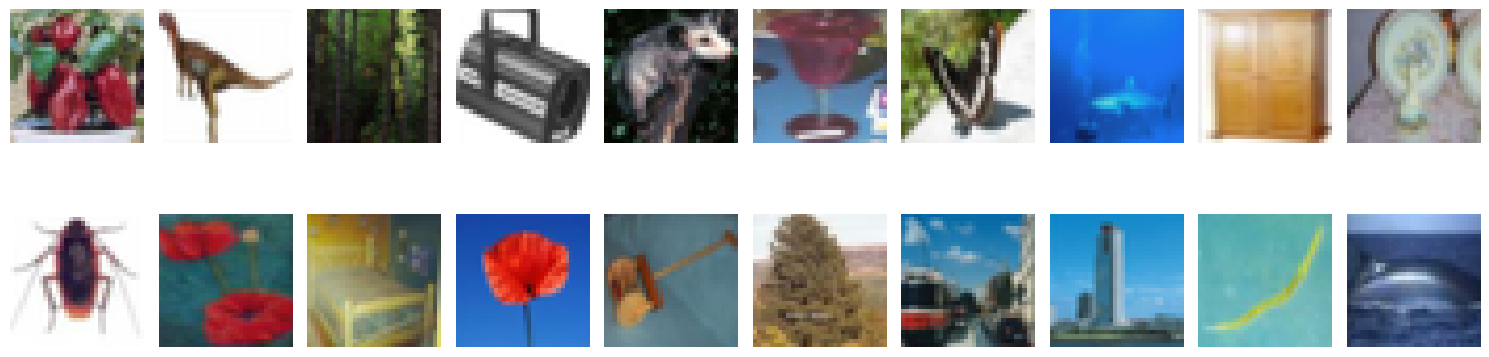


Transformed images from the sample, divided by transformation type
Rotation


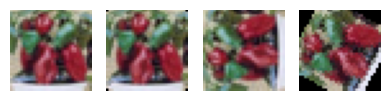

Brightness


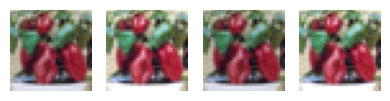

Noise


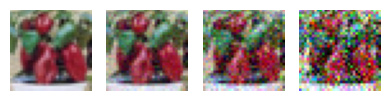

Blur


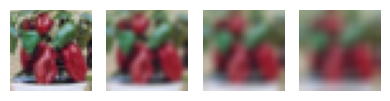

Crop


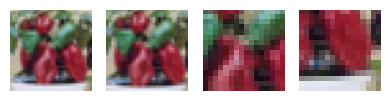

In [4]:
# Get a small images sample
original_images = it.get_sample_images_from_cifar100(seed=6174)

# Display original images from the sample
h, w = 2, 10
print("CIFAR random samples")
it.display_image_grid(original_images[:h*w], n_rows=h, n_cols=w, figsize=(15, 5))

# Create transformed dataset
transformed_dataset = it.create_transformation_dataset(original_images)

# Display transformed images
print("\nTransformed images from the sample, divided by transformation type")
for transformation_name, transformed_images in transformed_dataset.items():
    print(transformation_name.capitalize())
    it.display_image_grid(transformed_images[:4], n_rows=1, n_cols=4, figsize=(4, 4))

## Testing embedding functions

In [5]:
# num_samples = min(10 , len(original_images))
num_samples = len(original_images)

print(f"Testing embedding functions performance given {num_samples} image samples")
embd_time = emb_funcs.measure_embedding_times(original_images, embedding_functions, num_samples)

Testing embedding functions performance given 25 image samples
Time: 0.004s	Function: simple_color_histogram_embedding
Time: 0.4249s	Function: texture_embedding
Time: 0.001s	Function: composition_rules_embedding
Time: 0.0122s	Function: scene_complexity_embedding
Time: 0.001s	Function: downsample_embedding
Time: 0.006s	Function: edge_histogram_embedding
Time: 0.0013s	Function: fft_embedding
Time: 0.0199s	Function: sift_embedding
Time: 1.126s	Function: cnn_embedding
Time: 0.6816s	Function: resnet18_embedding
Time: 13.5111s	Function: object_composition_embedding
Time: 1.0099s	Function: semantic_concept_embedding
Time: 0.5258s	Function: color_palette_embedding


#### Excluding slow embedding functions

We decided to exclude inefficient embedding functions. The ineficiency criterion: > 0.1s calculation time per sample

In [29]:
max_time_per_sample = 0.1
good_embedding_functions = {}

too_slow = {key: round(embd_time[key] / num_samples, 4) for key in embd_time.keys() if embd_time[key] / num_samples > max_time_per_sample}
print(f"Inefficient embedding functions with calculation time per sample:\n{"\n".join(str(key) + ": " + str(value) + "s" for key, value in too_slow.items())}")

# use results on our machine for stability
# too_slow = ['object_composition_embedding',]

for key in embedding_functions:
    if key not in too_slow:
        good_embedding_functions[key] = embedding_functions[key]
print(f"\nRemaining time-efficient embedding functions:\n{"\n".join(str(name) for name in list(good_embedding_functions.keys()))}")

Inefficient embedding functions with calculation time per sample:
object_composition_embedding: 0.5404s

Remaining time-efficient embedding functions:
simple_color_histogram_embedding
texture_embedding
composition_rules_embedding
scene_complexity_embedding
downsample_embedding
edge_histogram_embedding
fft_embedding
sift_embedding
cnn_embedding
resnet18_embedding
semantic_concept_embedding
color_palette_embedding


# Evaluation of ANN methods

## Loading samples from Dataset image-net-200
We will load 16 image samples from each of 200 classes. To ensure distinctiveness from other classes, we took most similar images to one chosen by random, for each class. 
Reason behind this decision: as we don't have much of time and calculation resources, we wanted to reduce noise in the ANN methods comparison and evaluation results on small subset of image samples.

### Demonstration on a tiny set

C:\Users\hunte\OneDrive - Technion\ו2\מעבדה בניתוח והצגת נתונים 94295\Project\ANN-multi-modal\testing_imagenet.py:54: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  feature_extractor = tf.keras.applications.MobileNetV2(


Loading dataset...


100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


Finding similar pairs...
Done


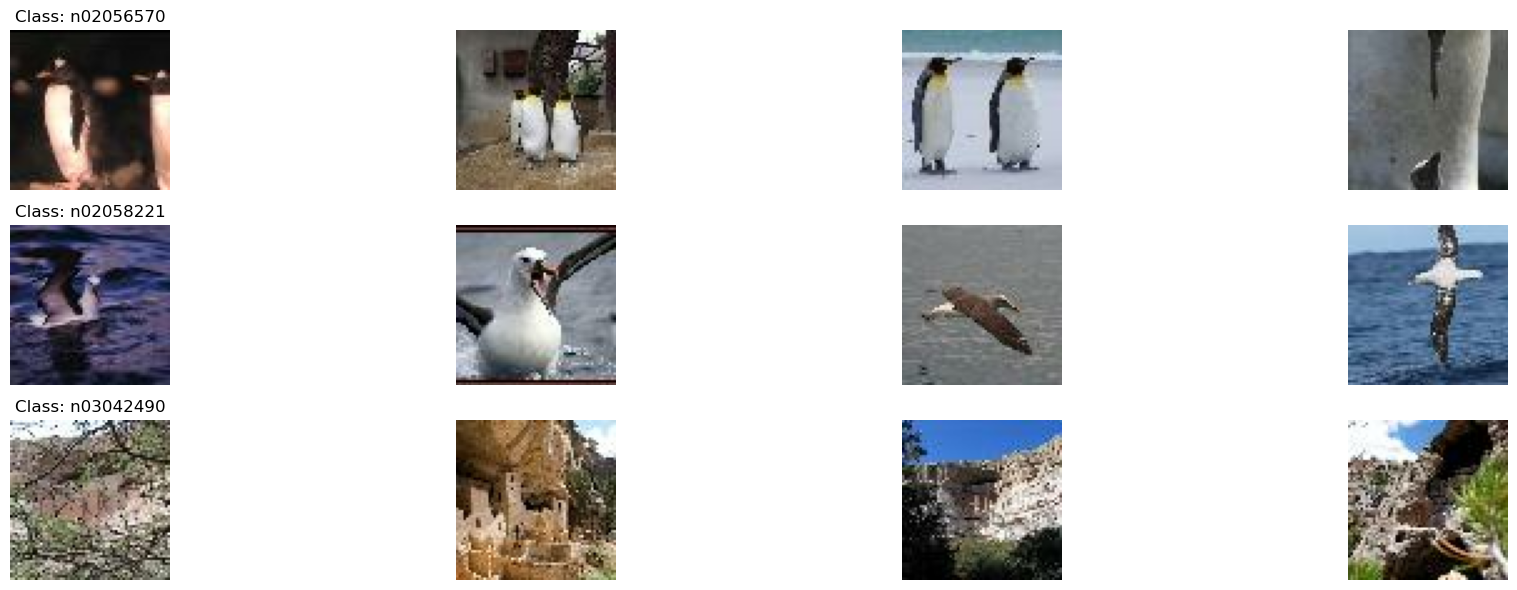

In [7]:
# Get 3 pairs of similar images (6 images total)
images, class_names = ti.get_similar_image_pairs_tiny(3 ,pair_size=4)
# Visualize the pairs with their class names
ti.visualize_tiny_imagenet_pairs(images, class_names , pair_size=4)

### Creating the dataset for testing

In [8]:
numer_of_images_per_class = 16
number_of_classes_from_tiny = 200

#### Load and preprocess image samples

In [9]:
# This loads and preprocesses the images only once. The rest of times loads from joblib. To change the dataset, delete files from joblib directory
pairs_file_path = './joblib/pair_similar_images.joblib'
classes_file_path = './joblib/class_names.joblib'
try:
    with open(pairs_file_path, 'rb') as file:
        pair_similar_images = joblib.load(file)
    with open(classes_file_path, 'rb') as file:
        class_names = joblib.load(file)
except:
    pair_similar_images, class_names = ti.get_similar_image_pairs_tiny(number_of_classes_from_tiny, pair_size = numer_of_images_per_class)
    os.makedirs("joblib", exist_ok=True)
    with open(pairs_file_path, 'wb') as file:
        joblib.dump(pair_similar_images, file)
    with open(classes_file_path, 'wb') as file:
        joblib.dump(class_names, file)

In [10]:
import matplotlib.pyplot as plt
def visualize_tiny_imagenet_pairs(images, class_names, pair_size=2):
    """
    Helper function to display the image pairs side by side with their class names

    Args:
        images (numpy array): Array of images to display
        class_names (list): List of class names for each pair
    """

    num_pairs = len(images) // pair_size
    fig, axes = plt.subplots(num_pairs, pair_size, figsize=(20 , 2 * num_pairs))

    if num_pairs == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_pairs):
        for j in range(pair_size):
            idx = i * pair_size + j
            axes[i, j].imshow(images[idx].astype('uint8'))
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f'Class: {class_names[i]}')

    plt.tight_layout()
    plt.show()

#### Embedd the samples using the list of embedding functions, filtered earlier

In [26]:
def get_all_embeddings(image, embedding_functions=good_embedding_functions):
    return [ef(image) for ef in embedding_functions.values()]

In [12]:
# The embedding calculations done only once. The rest of times loads from joblib. To change the dataset, delete files from joblib directory
embs_file_path = './joblib/pair_sample_embd.joblib'
try:
    with open(embs_file_path, 'rb') as file:
        pair_sample_embd = joblib.load(file)
except:
    pair_sample_embd = [get_all_embeddings(i) for i in tqdm(pair_similar_images)]
    os.makedirs("joblib", exist_ok=True)
    with open(embs_file_path, 'wb') as file:
        joblib.dump(pair_sample_embd, file)

## Evaluating the ANN methods

In [13]:
# The learn_class_weights method requires classes ids. Initializing them here
class_ids =[i for i in range(number_of_classes_from_tiny) for _ in range(numer_of_images_per_class) ]
ann_methods_list["learn_class_weights"] = mm_ann.wrapper_learn_class_weights(class_ids)

#### Re-verify embedding quality over large dataset
Check all embedding methods separately with each ANN method to compare them to their combination later.

In [14]:
results_dfs = []
for method_name, method in ann_methods_list.items():
    print(f"Evaluating for {method_name}")
    compare_subset_methods = {f"{method_name}_all": method}
    for i , name in enumerate(good_embedding_functions):
        compare_subset_methods[method_name + "_" + name] = mm_ann.limit_ann_functions_wrapper(method, [i])
    results_df = evann.evaluate_ann_search(pair_sample_embd, compare_subset_methods, num_searches=200, pair_size=numer_of_images_per_class, K=numer_of_images_per_class, display=False)
    results_dfs.append(results_df)

Evaluating for hnsw_simple_concatenation


100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Evaluating for LSH_simple_concatenation


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


Evaluating for separate indexing


100%|██████████| 13/13 [00:10<00:00,  1.29it/s]


Evaluating for just norm


100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Evaluating for Normalized and Scaled


100%|██████████| 13/13 [00:13<00:00,  1.02s/it]


Evaluating for learn_class_weights


100%|██████████| 13/13 [00:21<00:00,  1.62s/it]


Evaluating for Dimension Reduction


100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


Evaluating for robust multi index


  8%|▊         | 1/13 [02:39<31:54, 159.57s/it]C:\Users\hunte\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hunte\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hunte\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 13/13 [03:54<00:00, 18.03s/it]


Evaluating for Capped Distance


100%|██████████| 13/13 [01:06<00:00,  5.14s/it]


Evaluating for Tolerant ANN


100%|██████████| 13/13 [00:49<00:00,  3.82s/it]


Evaluating for Emphasis Close


100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


#### Metrics description
Metrics demonstrate scores related to class predictions. All metrics and times are averaged over all samples for each ANN method.
K here is the number of top nearest neighbors.
Mean Average Precision@K: MAP of the nearest K neighbors
Accuracy@K: Total matches / K
Recall@K: Proportion of ground truth neighbors (those from the same class) found in the top K
Index Build TIme: obvious
Average Search Time: obvious

In [16]:
emb_eval_results = pd.concat(results_dfs).reset_index(drop=True)
emb_eval_results

,Method Name,Mean Average Precision@K,Index Build Time,Average Search Time,Accuracy@K,Recall@K
0,hnsw_simple_concatenation_all,0.021057,2.686666,0.003260,0.012500,0.013333
1,hnsw_simple_concatenation_simple_color_histogr...,0.020679,0.188407,0.000056,0.014687,0.015667
2,hnsw_simple_concatenation_texture_embedding,0.014275,0.011097,0.000030,0.010625,0.011333
3,hnsw_simple_concatenation_composition_rules_em...,0.011290,0.012523,0.000054,0.007812,0.008333
4,hnsw_simple_concatenation_scene_complexity_emb...,0.015553,0.012045,0.000043,0.010937,0.011667
...,...,...,...,...,...,...
138,Emphasis Close_sift_embedding,0.018209,0.018100,0.002395,0.014687,0.015667
139,Emphasis Close_cnn_embedding,0.067588,3.718190,0.005743,0.054375,0.058000
140,Emphasis Close_resnet18_embedding,0.024110,0.047087,0.002325,0.019375,0.020667
141,Emphasis Close_semantic_concept_embedding,0.337520,0.034548,0.002186,0.320625,0.342000


As we can see, the clip model (semantic concept embedding) enormously outperforms all the other methods, including the combination of all methods... This finding kind of broke our motivation to finish the study, but we decided to continue comparing the methods, excluding the CLIP. It is still worth checking combinations versus individual embeddings.

In [30]:
good_embedding_functions.pop("semantic_concept_embedding") # exclude this because it outperforms all, breaking the sense of the study
good_embedding_functions.pop("resnet18_embedding") # this is the baseline embedding model we will compare our results to, so exclude

<bound method EmbeddingFunctions.resnet18_embedding of <embedding_functions.EmbeddingFunctions object at 0x000001B781AA51F0>>

In [18]:
emb_eval_results[["Mean Average Precision@K", "Accuracy@K", "Recall@K"]].corr()

,Mean Average Precision@K,Accuracy@K,Recall@K
Mean Average Precision@K,1.000000,0.999311,0.999311
Accuracy@K,0.999311,1.000000,1.000000
Recall@K,0.999311,1.000000,1.000000


# Results

In [31]:
results_df = evann.evaluate_ann_search(pair_sample_embd, ann_methods_list, num_searches=200, pair_size=numer_of_images_per_class, K=numer_of_images_per_class , display=False)

100%|██████████| 11/11 [05:07<00:00, 27.94s/it]


In [32]:
results_df

,Method Name,Mean Average Precision@K,Index Build Time,Average Search Time,Accuracy@K,Recall@K
0,hnsw_simple_concatenation,0.021739,3.025438,0.003076,0.012812,0.013667
1,LSH_simple_concatenation,0.021774,0.465050,0.000295,0.016875,0.018000
2,separate indexing,0.050062,2.406424,0.016410,0.048438,0.051667
3,just norm,0.031108,3.601192,0.012323,0.029687,0.031667
4,Normalized and Scaled,0.052307,4.670472,0.004312,0.042188,0.045000
5,learn_class_weights,0.019635,8.741416,0.003360,0.013437,0.014333
6,Dimension Reduction,0.051710,5.718525,0.000505,0.043125,0.046000
7,robust multi index,0.087880,3.222150,0.840615,0.095937,0.102333
8,Capped Distance,0.023195,0.393059,0.193010,0.018437,0.019667
9,Tolerant ANN,0.048492,39.866477,0.041767,0.038750,0.041333


As we can see, Robust Multi Index outperforms others by almost twice in all evaluation metrics. Normalized and Scaled, Dimension Reduction and Separate Indexing are in the second place.
In terms of time, these techniques are slower, of course, as they are generally more complex and involve heavy preprocessing calculations.

## Comparing multimodal to Resnet-18 embedding

### Embedding time comparison
Total time of the selected embedding functions versus the resnet18 embedding time

In [37]:
summ = 0
for name in good_embedding_functions.keys():
    print(f"Function: {name}, embedding time: {round(embd_time[name], 4)}s")
    summ += embd_time[name]
print("\n")
res_func = {"resnet18_embedding": emb_funcs.resnet18_embedding}
resnet_restime = emb_funcs.measure_embedding_times(original_images, res_func, num_samples)
print(f"\nAll other functions had a total embedding time of: {round(summ, 4)}s")

Function: simple_color_histogram_embedding, embedding time: 0.004s
Function: texture_embedding, embedding time: 0.4249s
Function: composition_rules_embedding, embedding time: 0.001s
Function: scene_complexity_embedding, embedding time: 0.0122s
Function: downsample_embedding, embedding time: 0.001s
Function: edge_histogram_embedding, embedding time: 0.006s
Function: fft_embedding, embedding time: 0.0013s
Function: sift_embedding, embedding time: 0.0199s
Function: cnn_embedding, embedding time: 1.126s
Function: color_palette_embedding, embedding time: 0.5258s

Time: 0.8761s	Function: resnet18_embedding

All other functions had a total embedding time of: 2.1222s


In [27]:
embd_res = [get_all_embeddings(i, res_func) for i in tqdm(pair_similar_images)]
embd_other = pair_sample_embd

100%|██████████| 3200/3200 [02:11<00:00, 24.36it/s]


In [45]:
results_resnet_df = evann.evaluate_ann_search(embd_res, ann_methods_list, num_searches=200, pair_size=numer_of_images_per_class, K=numer_of_images_per_class , display=False)

 64%|██████▎   | 7/11 [00:01<00:00,  6.24it/s]C:\Users\hunte\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hunte\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\hunte\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 11/11 [00:04<00:00,  2.55it/s]


In [46]:
results_resnet_df

,Method Name,Mean Average Precision@K,Index Build Time,Average Search Time,Accuracy@K,Recall@K
0,hnsw_simple_concatenation,0.024851,0.026019,0.000090,0.019688,0.021000
1,LSH_simple_concatenation,0.018861,0.017025,0.000113,0.016875,0.018000
2,separate indexing,0.024851,0.027047,0.000220,0.019688,0.021000
3,just norm,0.024110,0.030545,0.000516,0.019375,0.020667
4,Normalized and Scaled,0.027909,0.079275,0.000328,0.025937,0.027667
5,learn_class_weights,0.024851,0.291991,0.000113,0.019688,0.021000
6,Dimension Reduction,0.024984,0.094285,0.000145,0.020625,0.022000
7,robust multi index,0.013433,0.031539,0.010828,0.010313,0.011000
8,Capped Distance,0.011889,0.006509,0.002930,0.007500,0.008000
9,Tolerant ANN,0.024851,0.022015,0.000153,0.019688,0.021000
